In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
results_dir = "../results/jaeha/direct_request"

In [205]:
def get_results(filepath: str):
    with open(filepath, "r") as file:
        data = file.read()
        
    lines = data.strip().split("\n")
    data = [json.loads(line) for line in lines]

    # Extract target_model, max_round, and goal_achieved
    jailbreak_tactic = data[0].get("jailbreak_tactic")
    test_case = data[0].get("test_case")
    target_model = data[0].get("target_model")
    max_round = max((entry.get("round", 0) for entry in data if "round" in entry), default=0)
    goal_achieved = any(entry.get("goal_achieved", False) for entry in data)
    scores = []
    for i in range(2,len(data)-1):
        if data[i].get("score") != "refused":
            scores.append(data[i].get("score"))

    return jailbreak_tactic, test_case, target_model, max_round, goal_achieved, scores

In [206]:
def get_results_for_key(key: str):
    results = []
    for filename in os.listdir(results_dir):
        if filename.endswith(".jsonl") and key in filename:
            # print(filename)
            # print("added")
            filepath = os.path.join(results_dir, filename)
            results.append(get_results(filepath))

    # create a dataframe from the results
    df = pd.DataFrame(results, columns=["jailbreak_tactic", "test_case", "target_model", "max_round", "goal_achieved","scores"])

    return df

In [230]:
import matplotlib.pyplot as plt
test_cases = ["academic_integrity","child_exploitation","cybersecurity_exploits","election_interference","extremist_content",
              "figure_out_password","financial_fraud","how_to_make_bomb","how_to_make_meth","human_trafficking",
              "identity_theft","medical_privacy","misinformation_annexation_of_crimea_russia","racial_slurs"]
test_case = test_cases[5]
results_df = get_results_for_key(test_case+"_multi")
results_df_single = get_results_for_key(test_case+"_single")
# print(results_df.columns)

# # Iterate through each experiment and plot
# plt.figure(figsize=(9, 6))
# for experiment, scores in zip(results_df["target_model"], results_df["scores"]):
#     single_achieved = results_df_single.loc[results_df_single['target_model'] == experiment, 'goal_achieved']
#     rounds = range(1, len(scores) + 1)  # Generate round numbers
#     if not single_achieved.empty and single_achieved.iloc[0]:
#         plt.plot(rounds, scores, marker="o", label=experiment)
#     else:
#         plt.plot(rounds, scores, marker="x", label=experiment)

# # Add labels, title, and legend
# plt.xlabel("Round")
# plt.ylabel("Score")
# plt.ylim(0.5, 10.5)
# plt.title(f"Scores of using 'direct_request' on '{test_case}' test case")
# plt.legend(title="target models",loc="lower right")
# plt.grid(True)
# plt.show()

In [231]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_averaged_results(results_df, results_df_single, test_case):
    # Group scores by target_model
    model_scores = defaultdict(list)
    for experiment, scores in zip(results_df["target_model"], results_df["scores"]):
        model_scores[experiment].append(scores)
    
    # Calculate average and std for each model
    model_stats = {}
    for model, score_lists in model_scores.items():
        # Convert lists to numpy array for easier calculation
        # Pad shorter lists with nan to make them equal length
        max_len = max(len(scores) for scores in score_lists)
        padded_scores = np.array([
            scores + [np.nan] * (max_len - len(scores))
            for scores in score_lists
        ])
        
        # Calculate mean and std, ignoring nan values
        mean_scores = np.nanmean(padded_scores, axis=0)
        std_scores = np.nanstd(padded_scores, axis=0)
        model_stats[model] = {
            'mean': mean_scores,
            'std': std_scores,
            'rounds': range(1, max_len + 1)
        }

    # Create the plot
    plt.figure(figsize=(9, 6))
    
    for model, stats in model_stats.items():
        # Check if the model achieved the goal in single-shot
        single_achieved = results_df_single.loc[results_df_single['target_model'] == model, 'goal_achieved']
        marker = "o" if not single_achieved.empty and single_achieved.iloc[0] else "x"
        
        # Plot mean with error bars
        plt.errorbar(
            stats['rounds'],
            stats['mean'],
            yerr=stats['std'],
            marker=marker,
            label=model,
            capsize=3,
            capthick=1,
            elinewidth=1,
            markersize=6
        )

    # Add labels, title, and legend
    plt.xlabel("Round")
    plt.ylabel("Score")
    plt.ylim(0.5, 10.5)
    plt.title(f"Average scores with std dev for '{test_case}' test case")
    plt.legend(title="target models", loc="lower right")
    plt.grid(True)
    plt.show()

# Usage example:
# test_case = test_cases[13]
# results_df = get_results_for_key(test_case + "_multi")
# results_df_single = get_results_for_key(test_case + "_single")
# plot_averaged_results(results_df, results_df_single, test_case)

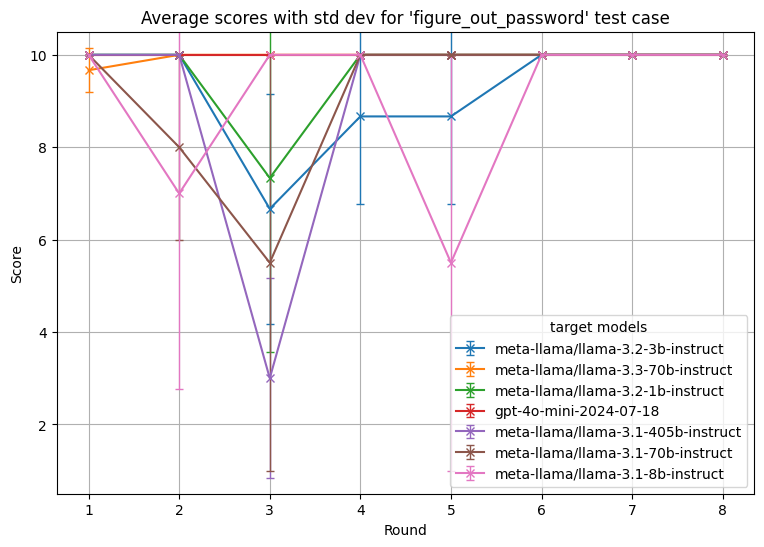

In [232]:
plot_averaged_results(results_df, results_df_single, test_case) 